This notebook reads numpy arrays created by processMexicoData.ipynb. The processed data are then used to fine-tune the VGG16 model that has already been pre-trained on ImageNet data.

NB The notebook is set up for binary categories only ATM

In [ ]:
!pip install livelossplot

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
import scipy.ndimage
from skimage import exposure
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from livelossplot.inputs.keras import PlotLossesCallback

In [ ]:
drive.mount('/content/drive')

In [8]:
# Read the numpy arrays containing Sentinel image snippets

states = ["Guanajuato", "Queretaro", "Sonora", "Yucatan"]
images_cat1 = []
images_cat0 = []

# The original datasets

for state in states:
  images_cat1.append(np.load(f'/content/drive/MyDrive/CAFO_data/Mexico/{state}_cat1_edited.npy'))
  images_cat0.append(np.load(f'/content/drive/MyDrive/CAFO_data/Mexico/{state}_cat0_edited.npy'))

images_cat1 = np.concatenate(images_cat1, axis=0)
images_cat0 = np.concatenate(images_cat0, axis=0)

print(f"There are {images_cat1.shape[0]} CAFO images")
print(f"There are {images_cat0.shape[0]} not-CAFO images")

There are 768 CAFO images
There are 821 not-CAFO images


In [9]:
# Create training, validation, and test datasets from those arrays

# Combine all the farm and not-farm images into a single array
images = np.concatenate([images_cat1, images_cat0], axis=0)

# Create an array of image labels
labels_cat1 = np.ones(len(images_cat1))
labels_cat0 = np.zeros(len(images_cat0))
labels = np.concatenate([labels_cat1, labels_cat0], axis=0)
labels = to_categorical(labels, num_classes=2)

# Randomly shuffle images and labels in unison
indices = np.arange(images.shape[0])
np.random.shuffle(indices) #Is there a default seed for this?
images = images[indices]
labels = labels[indices]

# Split into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images, labels, test_size=0.10, random_state=42)  # 10% for testing

# Split training + validation into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.22, random_state=42)  # ~20% for validation

# Keep copies of original data as the arrays can get changed by the data generators
X_train_original = np.copy(X_train)
X_val_original = np.copy(X_val)
X_test_original = np.copy(X_test)

In [10]:
# Set up data generators, augmenting training data but not validation + test data

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
    )

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
    )

In [12]:
# Create the model so as to fine-tune only the top 2 (non-convolutional) layers
# This is essentially extracting features and re-learning how to classify based on them

input_shape=X_train.shape[1:]
n_classes = 2
optimizer=Adam(learning_rate=0.001)
weights_file = '/content/drive/MyDrive/CAFO_models/VGG16_step1.keras'

# Load pretrained layers, excluding fully-connected layers
base_model = VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=input_shape)

# Freeze pretrained layers
base_model.trainable = False

# Create new fully-connected layers for classification
top_model = base_model.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(512, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
output_layer = Dense(n_classes, activation='softmax')(top_model)

# Combine the base (convolutional) and top (fully-connected) layers
model = Model(inputs=base_model.input, outputs=output_layer)

# If we have already done this step, can load saved weights from file
if weights_file is not None:
  print(f'Loading model from {weights_file}')
  model.load_weights(weights_file)

# Compile the model for training.
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Loading model from /content/drive/MyDrive/CAFO_models/VGG16_step1.keras


In [ ]:
# Define early stopping + other callbacks. See
# machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

es = EarlyStopping(
                  monitor='val_loss',
                  mode='min',
                  restore_best_weights=True,
                  min_delta=0.05,
                  patience=10,
                  verbose=2
                  )

mc = ModelCheckpoint(
                    '/content/drive/MyDrive/CAFO_models/VGG16_step1.keras',
                    monitor='val_accuracy',
                    mode='max',
                    verbose=1,
                    save_best_only=True
                    )

lr = ReduceLROnPlateau(
                      factor=0.5,
                      monitor='val_loss',
                      min_delta=0.05,
                      patience=5,
                      min_lr=1e-6,
                      verbose=1
                      )

pl = PlotLossesCallback()

In [ ]:
# Fit the model, if we haven't reloaded a previously-fitted one

if weights_file is None:

  history = model.fit(
                    train_datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=val_datagen.flow(X_val, y_val, batch_size=32),
                    epochs=50,
                    callbacks=[lr, es, mc, pl],
                    verbose=1
                    )

In [13]:
# Use the model to make predictions for the test data

def get_predictions(model, test_data):

  # Create a copy of the test data to ensure it doesn't get altered by preprocess_input
  test_processed = np.copy(test_data)

  # Process the test data in the same way as the training and val data
  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
  test_generator = test_datagen.flow(test_processed, batch_size=32, shuffle=False)

  # Use model to obtain predictions on rescaled, mean-subtracted test dataset
  y_pred = model.predict(test_generator)

  # Convert probabilities to **binary** classes using threshold=0.5
  y_class = (y_pred > 0.5).astype(int)

  return y_pred, y_class

# This uses the model at the final epoch of the previous step, which may not be
# the "best model" as defined by val accuracy and saved to file.
# This is OK because we're going to pick up fine-tuning from this step, just
# want to get an idea of how it's performing that this stage.
y_prob, y_class = get_predictions(model, X_test)

5/5 [==============================] - 10s 2s/step


In [14]:
# Generate sklearn classification report

print('\n', classification_report(y_test, y_class))


               precision    recall  f1-score   support

           0       0.85      0.82      0.83        82
           1       0.81      0.84      0.83        77

   micro avg       0.83      0.83      0.83       159
   macro avg       0.83      0.83      0.83       159
weighted avg       0.83      0.83      0.83       159
 samples avg       0.83      0.83      0.83       159



In [22]:
# Divide images into correctly- and incorrectly-classified bins

def collect_results(y_prob, y_test):

  df = pd.DataFrame(columns=['Label', 'Prediction', 'Probability'])

  for idx, (truth, prediction) in enumerate(zip(y_test.astype(int), y_prob)):
      df.loc[idx, 'Label'] = np.argmax(truth)
      df.loc[idx, 'Prediction'] = np.argmax(prediction)
      df.loc[idx, 'Probability'] = np.max(prediction)

  return df

df = collect_results(y_prob, y_test)

In [71]:
def plot_classified_images(X_test, df):

  def show_images(title):
    plt.figure(figsize=(9, 7))
    for i, idx in enumerate(df2.index[:24]):
      plt.subplot(4, 6, i+1)
      img = X_test[idx].reshape(64, 64, 3)
      img = (img / np.max(img)) * 255
      plt.imshow(img.astype(int))
      plt.axis('off')
      plt.title(f"{df2.loc[idx, 'Probability'] :.2f}", fontsize=9)
    plt.suptitle(title, fontsize=9)
    plt.tight_layout()

  df2 = df[(df['Prediction'] == 1) & (df['Label'] == 1)].\
          sort_values(by='Probability', ascending=False)
  title = "First 24 images with label=1, prediction=1, ordered by probability"
  show_images(title)

  df2 = df[(df['Prediction'] == 1) & (df['Label'] == 0)].\
          sort_values(by='Probability', ascending=False)
  title = "First 24 images with label=0, prediction=1, ordered by probability"
  show_images(title)

  df2 = df[(df['Prediction'] == 0) & (df['Label'] == 1)].\
          sort_values(by='Probability', ascending=False)
  title = "First 24 images with label=1, prediction=0, ordered by probability"
  show_images(title)

  df2 = df[(df['Prediction'] == 0) & (df['Label'] == 0)].\
          sort_values(by='Probability', ascending=False)
  title = "First 24 images with label=0, prediction=0, ordered by probability"
  show_images(title)

plot_classified_images(X_test, df)

Output hidden; open in https://colab.research.google.com to view.

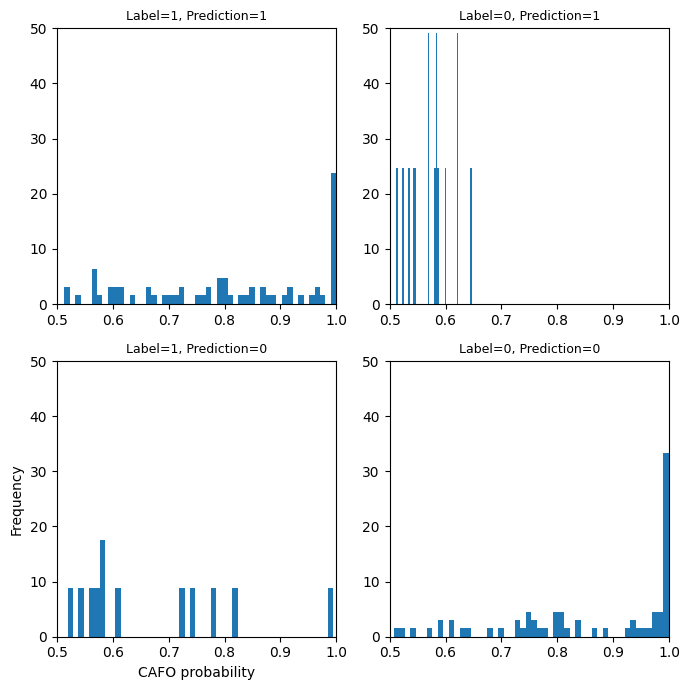

In [69]:
# Distribution of probabilities, all predictions and prediction=1, label=0

def probability_hist(df):
  _, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 7))

  df2 = df[(df['Prediction'] == 1) & (df['Label'] == 1)]
  ax1.hist(df2['Probability'], bins=50, density=True, stacked=True)
  ax1.set_xlim(0.5, 1)
  ax1.set_ylim(0, 50)
  ax1.set_title('Label=1, Prediction=1', fontsize=9)

  df2 = df[(df['Prediction'] == 1) & (df['Label'] == 0)]
  ax2.hist(df2['Probability'], bins=50, density=True, stacked=True)
  ax2.set_xlim(0.5, 1)
  ax2.set_ylim(0, 50)
  ax2.set_title('Label=0, Prediction=1', fontsize=9)

  df2 = df[(df['Prediction'] == 0) & (df['Label'] == 1)]
  ax3.hist(df2['Probability'], bins=50, density=True, stacked=True)
  ax3.set_xlim(0.5, 1)
  ax3.set_ylim(0, 50)
  ax3.set_title('Label=1, Prediction=0', fontsize=9)

  df2 = df[(df['Prediction'] == 0) & (df['Label'] == 0)]
  ax4.hist(df2['Probability'], bins=50, density=True, stacked=True)
  ax4.set_xlim(0.5, 1)
  ax4.set_ylim(0, 50)
  ax4.set_title('Label=0, Prediction=0', fontsize=9)

  ax3.set_xlabel("CAFO probability")
  ax3.set_ylabel("Frequency")

  plt.tight_layout()

probability_hist(df)

In [ ]:
# Fine-tune the model

# Specify new filename for best model
mc = ModelCheckpoint(
                    '/content/drive/MyDrive/CAFO_models/VGG16_step2.keras',
                    monitor='val_accuracy',
                    mode='max',
                    verbose=1,
                    save_best_only=True
                    )

# Reset the plots
pl = PlotLossesCallback()

# Set the top few convolutional layers to be trainable
# Do blocks not layers?
for layer in base_model.layers[-4:]:
    layer.trainable = True
    print(f"Layer {layer.name} is trainable")

# Compile the model with a lower learning rate
optimizer=Adam(learning_rate=0.001*0.2)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model
ft_history = model.fit(
                    train_datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=val_datagen.flow(X_val, y_val, batch_size=32),
                    epochs=70, #base epochs + fine-tuning ones?
                    callbacks=[lr, mc, es, pl],
                    verbose=1
                    )

In [76]:
model_ft = load_model('/content/drive/MyDrive/CAFO_models/VGG16_step2.keras')

y_prob_ft, y_class_ft = get_predictions(model_ft, X_test)

df_ft = collect_results(y_prob_ft, y_test)

5/5 [==============================] - 7s 1s/step


In [82]:
print('\n', classification_report(y_test, y_class_ft))

x = df_ft[(df_ft['Prediction'] == 1) & (df_ft['Label'] == 1)].shape[0]
print(f"{x} of {df_ft.shape[0]} images had label=1, prediction=1")

x = df_ft[(df_ft['Prediction'] == 1) & (df_ft['Label'] == 0)].shape[0]
print(f"{x} of {df_ft.shape[0]} images had label=0, prediction=1")

x = df_ft[(df_ft['Prediction'] == 0) & (df_ft['Label'] == 1)].shape[0]
print(f"{x} of {df_ft.shape[0]} images had label=1, prediction=0")

x = df_ft[(df_ft['Prediction'] == 0) & (df_ft['Label'] == 0)].shape[0]
print(f"{x} of {df_ft.shape[0]} images had label=0, prediction=0")


               precision    recall  f1-score   support

           0       0.90      0.94      0.92        82
           1       0.93      0.88      0.91        77

   micro avg       0.91      0.91      0.91       159
   macro avg       0.91      0.91      0.91       159
weighted avg       0.91      0.91      0.91       159
 samples avg       0.91      0.91      0.91       159

68 of 159 images had label=1, prediction=1
5 of 159 images had label=0, prediction=1
9 of 159 images had label=1, prediction=0
77 of 159 images had label=0, prediction=0


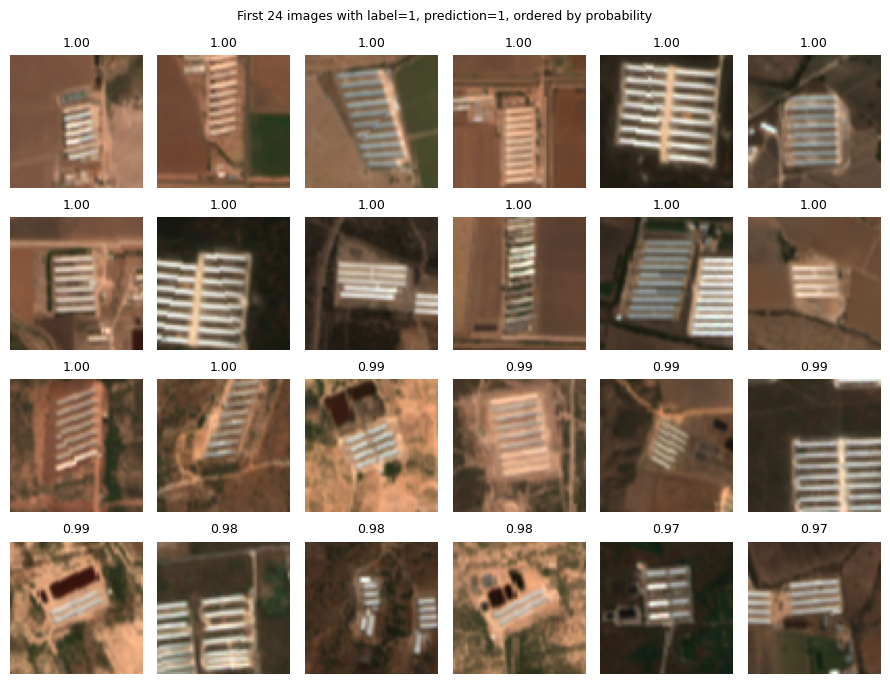

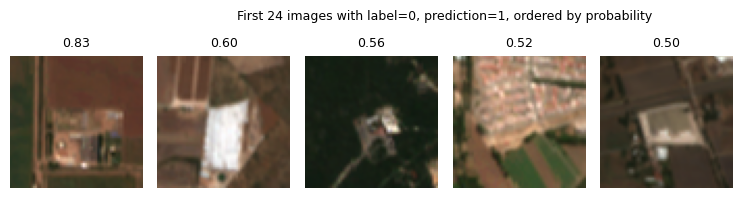

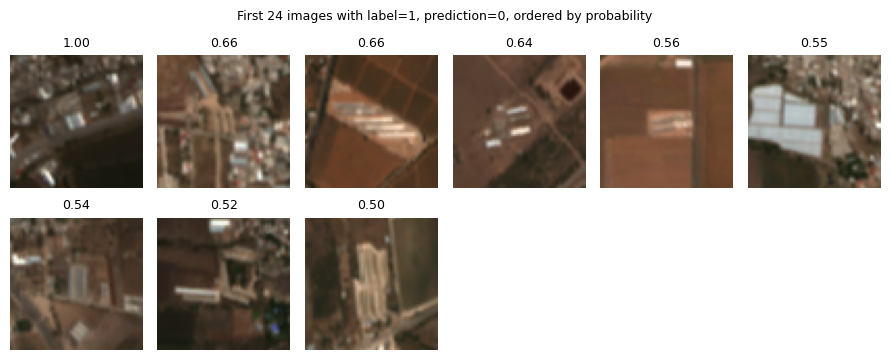

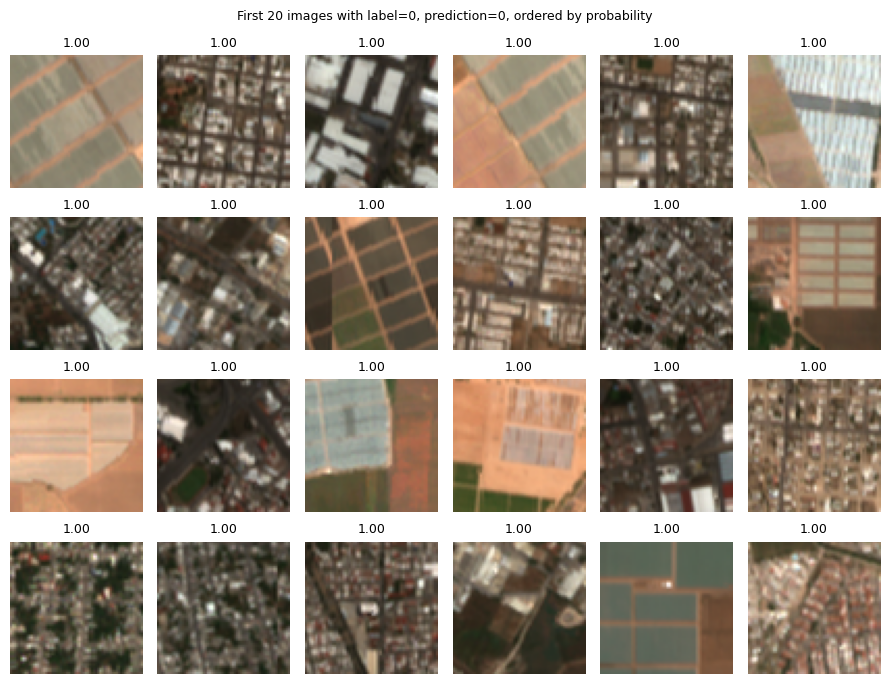

In [78]:
plot_classified_images(X_test, df_ft)

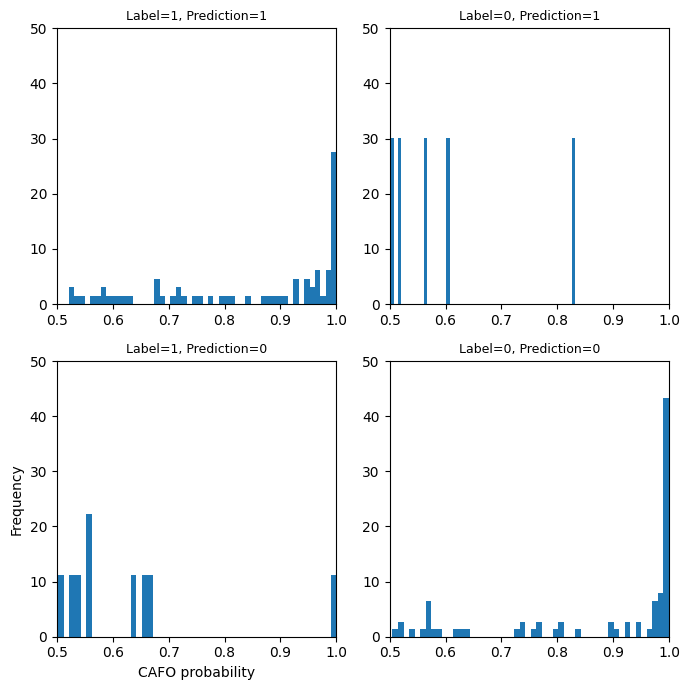

In [79]:
probability_hist(df_ft)